<a href="https://colab.research.google.com/github/ricardodeazambuja/MaskDetection-EdgeTPU-RPI0/blob/main/EdgeTPU_MaskDetection_Training_(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FaceMask Detection on edgetpu using mobiledet ssdlite

Modified from https://github.com/Namburger/edgetpu-ssdlite-mobiledet-retrain

In [ ]:
# Import tensorflow 1.x and install tf_slim
%tensorflow_version 1.x
!pip install -q tf_slim
!pip show tensorflow

TensorFlow 1.x selected.
     |████████████████████████████████| 358kB 6.5MB/s 
Name: tensorflow
Version: 1.15.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /tensorflow-1.15.2/python3.7
Requires: keras-preprocessing, astor, grpcio, numpy, protobuf, wheel, gast, keras-applications, opt-einsum, tensorboard, absl-py, tensorflow-estimator, six, termcolor, google-pasta, wrapt
Required-by: stable-baselines, magenta, fancyimpute


In [ ]:
# Install protobuf-compiler and object detection API.
!apt-get install protobuf-compiler imagemagick > /dev/null 2>&1

!git clone https://github.com/tensorflow/models.git /content/models > /dev/null 2>&1

import os
os.environ['PYTHONPATH'] += ':/content/models/research/'
os.environ['PYTHONPATH'] += ':/content/models/research/slim/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection/utils/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection'

%cd /content/models/research
# Compile all the protobuf dependencies.
!protoc object_detection/protos/*.proto --python_out=.
# Set up and install the object detection API.
!cp object_detection/packages/tf1/setup.py .
!python -m pip install . > /dev/null
# Run a test to make sure setup is correct.
!python object_detection/builders/model_builder_test.py > /dev/null

/content/models/research


### Datasets

https://makeml.app/datasets/mask has only 853 images

https://www.kaggle.com/ivandanilovich/medical-masks-dataset-images-tfrecords has 1148 (but you need to log in to download it)

In [ ]:
# Download the Mask Dataset from MakeML: https://makeml.app/datasets/mask
# License: Public Domain Mark
!mkdir /content/dataset
%cd /content/dataset
!wget https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/Mask/MaskPascalVOC.zip
!unzip MaskPascalVOC.zip > /dev/null 2>&1
!rm -r __* # remove MacOS cache

/content/dataset
--2021-05-07 16:20:56--  https://arcraftimages.s3-accelerate.amazonaws.com/Datasets/Mask/MaskPascalVOC.zip
Resolving arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)... 13.35.111.208
Connecting to arcraftimages.s3-accelerate.amazonaws.com (arcraftimages.s3-accelerate.amazonaws.com)|13.35.111.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 417606530 (398M) [application/zip]
Saving to: ‘MaskPascalVOC.zip’

MaskPascalVOC.zip   100%[===================>] 398.26M  71.2MB/s    in 5.7s    

2021-05-07 16:21:02 (70.3 MB/s) - ‘MaskPascalVOC.zip’ saved [417606530/417606530]



In [ ]:
# Mount Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# I downloaded the Kaggle beforehand to avoid logging in, etc:
# !cp /content/drive/MyDrive/Checkpoints/mask_old/datasets/kaggle_masks.zip /content/dataset/kaggle_masks.zip

In [ ]:
ls /content/dataset

annotations/  images/  MaskPascalVOC.zip


In [ ]:
# !unzip kaggle_masks.zip > /dev/null 2>&1
!rm -rf kaggle_masks.zip MaskPascalVOC.zip

In [ ]:
ls /content/dataset

annotations/  images/


In [ ]:
# Copy everything to the same directory
# !cp /content/dataset/medical-masks-dataset/images/* /content/dataset/images/

In [ ]:
!ls /content/dataset/images | wc -l

853


In [ ]:
# Copy everything to the same directory
# !cp /content/dataset/medical-masks-dataset/labels/* /content/dataset/annotations/

In [ ]:
!ls /content/dataset/annotations | wc -l

853


In [ ]:
# !rm -rf /content/dataset/images/medical-masks-dataset/

In [ ]:
# !cat /content/dataset/label_map.pbtxt

In [ ]:
# Lets create a mask_label_map.pbtxt file

%%file mask_label_map.pbtxt
item {
  id: 1
  name: 'mask'
}

item {
  id: 2
  name: 'no_mask'
}

item {
  id: 3
  name: 'poor_mask'
}

Writing mask_label_map.pbtxt


In [ ]:
import glob
import os
import shutil
import numpy as np

In [ ]:
!rm -rf "/content/dataset/train"
!rm -rf "/content/dataset/test"

seed = 42
test_perc = 0.1

img_list = glob.glob("/content/dataset/images/*")
img_list_filenames = [i.split("/")[-1] for i in img_list]

ann_list = glob.glob("/content/dataset/annotations/*.xml")
ann_list_filenames = [i.split("/")[-1] for i in ann_list]

# Let's make sure we don't have files with the same name...
# ... and hope the different datasets are not reusing images!
img_list = sorted(list(set(img_list_filenames)))
ann_list = sorted(list(set(ann_list_filenames)))

assert len(img_list)==len(ann_list), "They should have the same length..."

rs = np.random.RandomState(seed)
rnd_indices = list(range(len(img_list)))
rs.shuffle(rnd_indices)

if not os.path.exists("/content/dataset/train"):
  os.mkdir("/content/dataset/train")

if not os.path.exists("/content/dataset/test"):
  os.mkdir("/content/dataset/test")


n_test = int(len(img_list)*test_perc)
print(f"Test set size: {n_test}")
print(f"Train set size: {len(img_list)-n_test}")
#
# Both datasets use annotation as the same name as the image
#
for i in range(len(img_list)):
  if i <= n_test:
    shutil.copy(os.path.join("/content/dataset/images/",img_list[i]), f"/content/dataset/test/{i}.{img_list[i].split('.')[-1]}")
    shutil.copy(os.path.join("/content/dataset/annotations/",ann_list[i]), f"/content/dataset/test/{i}.xml")
  else:
    shutil.copy(os.path.join("/content/dataset/images/",img_list[i]), f"/content/dataset/train/{i}.{img_list[i].split('.')[-1]}")
    shutil.copy(os.path.join("/content/dataset/annotations/",ann_list[i]), f"/content/dataset/train/{i}.xml")

Test set size: 85
Train set size: 768


In [ ]:
ls /content/dataset/train | head -n 10

100.png
100.xml
101.png
101.xml
102.png
102.xml
103.png
103.xml
104.png
104.xml


In [ ]:
# Now, let's download our ssdlite mobiledet pretrained model from tensorflow's model zoo.
!mkdir /content/pretrained_model
%cd /content/pretrained_model
!wget http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz
!tar xvf ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz

/content/pretrained_model
--2021-04-26 17:43:47--  http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 66.102.1.128, 2a00:1450:400c:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|66.102.1.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156413934 (149M) [application/x-tar]
Saving to: ‘ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz’

ssdlite_mobiledet_e 100%[===================>] 149.17M  54.5MB/s    in 2.7s    

2021-04-26 17:43:51 (54.5 MB/s) - ‘ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz’ saved [156413934/156413934]

ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/
ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/
ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/model.ckpt-400000.data-00000-of-00001
ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/fp32/model.ckpt-400000.ind

In [ ]:
!rm -rf /content/dataset/train_labels.csv
!rm -rf /content/dataset/test_labels.csv

# This script will turn our xml files from each image to a single label file.
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

label_translator = {"with_mask":"with_mask",
                    "without_mask": "without_mask",
                    "mask_weared_incorrect":"mask_weared_incorrect",
                    "mask": "with_mask",
                    "none": "without_mask",
                    "poor": "mask_weared_incorrect"}
                    
def xml_to_csv(path):
  xml_list = []
  file_list = list(glob.glob(path + '/*.jpg'))+list(glob.glob(path + '/*.png'))
  for xml_file in file_list:
    tree = ET.parse(os.path.join(path,xml_file.split('/')[-1].split('.')[0]+".xml"))
    root = tree.getroot()
    for member in root.findall('object'):
      # fix names in different datasets
      name = label_translator[member.find('name').text]
      # fix problems with bbox https://stackoverflow.com/a/64407725
      xmin = int(member.find('bndbox')[0].text)
      ymin = int(member.find('bndbox')[1].text)
      xmax = int(member.find('bndbox')[2].text)
      ymax = int(member.find('bndbox')[3].text)
      xmin = np.min((xmin, xmax))
      xmax = np.max((xmin, xmax))
      ymin = np.min((ymin, ymax))
      ymax = np.max((ymin, ymax))
      width = int(root.find('size')[0].text)
      height = int(root.find('size')[1].text)
      value = (xml_file.split('/')[-1],
        width,
        height,
        name,
        xmin,
        ymin,
        xmax,
        ymax
        )
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name)
  return xml_df


def get_labels_from_image_dir():
  for name in ['test', 'train']:
    full_dir = '/content/dataset/' + name + '/'
    label_file = '/content/dataset/' + name + '_labels.csv'
    image_path = full_dir
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv(label_file, index=None)

get_labels_from_image_dir()

print('Training labels:')
!head -n 20 /content/dataset/train_labels.csv
print('\nTesting labels:')
!head -n 20 /content/dataset/test_labels.csv

Training labels:
filename,width,height,class,xmin,ymin,xmax,ymax
337.png,400,280,without_mask,101,49,134,91
337.png,400,280,without_mask,133,75,166,111
337.png,400,280,with_mask,228,102,263,148
337.png,400,280,with_mask,346,62,367,101
693.png,400,267,with_mask,19,89,37,107
693.png,400,267,with_mask,45,79,64,103
693.png,400,267,with_mask,97,81,113,101
693.png,400,267,with_mask,175,80,193,103
693.png,400,267,with_mask,158,83,170,99
693.png,400,267,with_mask,210,93,224,108
693.png,400,267,with_mask,244,93,252,104
693.png,400,267,with_mask,269,87,286,104
693.png,400,267,with_mask,308,88,322,103
495.png,301,400,without_mask,145,200,240,324
466.png,400,225,with_mask,3,112,12,122
466.png,400,225,with_mask,27,178,35,186
466.png,400,225,with_mask,25,107,35,117
466.png,400,225,with_mask,51,108,61,120
466.png,400,225,without_mask,43,137,53,148

Testing labels:
filename,width,height,class,xmin,ymin,xmax,ymax
46.png,301,400,without_mask,152,192,239,319
34.png,400,295,without_mask,106,69,124,89
34.p

In [ ]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict


#
# Class weights (unbalanced dataset)
# Considering: {'without_mask': 1358, 'with_mask': 6568, 'mask_weared_incorrect': 251}
# https://stackoverflow.com/a/51985479
# https://github.com/tensorflow/models/blob/991f75e200721267302291862cd9bf936ca06f90/research/object_detection/core/losses.py#L87
class_names = ['with_mask', 'without_mask', 'mask_weared_incorrect']
class_weights = [0.5, 0.8, 1.0] # I'm trying to make it better at poor mask, but it's not working
# class_weights = [1.0, 1.0, 1.0] # if you don't care about unbalance...

class2weight = dict(zip(class_names, class_weights))

class2int = dict(zip(class_names, [1,2,3]))

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path, type=None):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = [] 
    classes = []
    weights = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class2int[row['class']])
        weights.append(class2weight[row['class']]) # add class weights (unbalanced dataset)

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
        'image/object/weight': dataset_util.float_list_feature(weights),  # add class weights (unbalanced dataset)
    }))
    return tf_example


def main():
  for name in ['test', 'train']:
    writer = tf.python_io.TFRecordWriter('/content/dataset/' + name + '.record')
    path = os.path.join('/content/dataset/'+ name)
    examples = pd.read_csv('/content/dataset/' + name + '_labels.csv')
    grouped = split(examples, 'filename')
    for group in grouped:
      tf_example = create_tf_example(group, path)
      writer.write(tf_example.SerializeToString())
    writer.close()

main()

print("Done!")

Done!


### Randomly visualize samples from the datasets to make sure they make sense...

mask_weared_incorrect
{'without_mask': 632, 'with_mask': 2952, 'mask_weared_incorrect': 109}


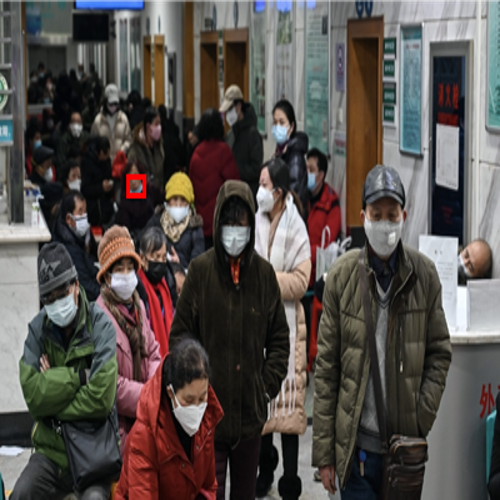

In [ ]:
from PIL import Image, ImageDraw

ds_type = "train"

with open('/content/dataset/'+ds_type+'_labels.csv' ,'r') as f:
  # filename,width,height,class,xmin,ymin,xmax,ymax
  csv_file = f.read().splitlines()[1:]

labels = {}
for csv_data in csv_file:
  filename, _, _, label, xmin,ymin,xmax, ymax = csv_data.split(',')
  if label in labels:
    labels[label]+=1
  else:
    labels[label]=1

sample_idx = np.random.randint(0, len(csv_file))
filename, _, _, label, xmin,ymin,xmax, ymax = csv_file[sample_idx].split(',')
img = Image.open('/content/dataset/'+ds_type+"/"+filename)
draw = ImageDraw.Draw(img)
draw.rectangle([(int(xmin), int(ymin)), (int(xmax), int(ymax))], width=3, outline='red')
# draw.text((int(xmin)+5, int(ymin)),label,fill='red')
print(label)
print(labels) # 8177, 0.166075578, 0.803228568, 32.5776892 => 0.00495054, 0.02394338, 0.97110608
img.resize((500,500))

### Prepare config for training
I went crazy with the data augmentation options...

In [ ]:
%%file /content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4_training.config
model {
  ssd {
    num_classes: 3
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobiledet_edgetpu"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 4e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.03
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.97
          center: true
          scale: true
          epsilon: 0.001
          train: true
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: false
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 4e-05
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.03
            }
          }
          activation: RELU_6
          batch_norm {
            decay: 0.97
            center: true
            scale: true
            epsilon: 0.001
            train: true
          }
        }
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.8
        kernel_size: 3
        box_code_size: 4
        apply_sigmoid_to_scores: false
        class_prediction_bias_init: -4.6
        use_depthwise: true
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-08
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
        use_static_shapes: true
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
          delta: 1.0
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 2.0
          alpha: 0.75
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
  }
}
train_config {
  batch_size: 64
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_adjust_brightness {
    }
  }
  data_augmentation_options {
    random_distort_color {
    }
  } 
  data_augmentation_options {
    random_jitter_boxes {
    }
  }
  data_augmentation_options {
    random_image_scale {
    }
  }
  # data_augmentation_options {
  #   random_black_patches {
  #   }
  # }
  # data_augmentation_options {
  #   random_vertical_flip {
  #   }
  # }
  data_augmentation_options {
    random_adjust_contrast {
    }
  }
  data_augmentation_options {
    random_adjust_saturation {
    }
  }
  # data_augmentation_options {
  #   random_rotation90 {
  #   }
  # }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
  sync_replicas: true
  optimizer {
    # This is for the first run...
    # momentum_optimizer {
    #   learning_rate {
    #     cosine_decay_learning_rate {
    #       learning_rate_base: 0.8
    #       total_steps: 400000
    #       warmup_learning_rate: 0.13333
    #       warmup_steps: 2000
    #     }
    #   }
    #   momentum_optimizer_value: 0.9
    # }

    # I didn't have time to check the documentation, 
    # so this is my "hack" for the final epochs...
    momentum_optimizer {
      learning_rate{
        manual_step_learning_rate {
          initial_learning_rate: 0.0001
          schedule {
            step: 900000
            learning_rate: .00001
          }
        }
      }
    }
    use_moving_average: false
  }
  fine_tune_checkpoint: "/content/pretrained_model/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19/uint8/model.ckpt"
  num_steps: 2000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 32
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
}
train_input_reader {
  label_map_path: "/content/dataset/mask_label_map.pbtxt"
  tf_record_input_reader {
    input_path: "/content/dataset/train.record"
  }
}
eval_config {
  num_examples: 85
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
}
eval_input_reader {
  label_map_path: "/content/dataset/mask_label_map.pbtxt"
  shuffle: true
  num_epochs: 1
  tf_record_input_reader {
    input_path: "/content/dataset/test.record"
  }
}
graph_rewriter {
  quantization {
    delay: 0
    weight_bits: 8
    activation_bits: 8
  }

}

Overwriting /content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4_training.config


In [ ]:
# !rm -rf /content/drive/MyDrive/Checkpoints/mask_full/ 
!mkdir /content/drive/MyDrive/Checkpoints/mask_full/

In [ ]:
# Change into the research directory and begin training.
# Colab will kick you out after around 2000 epochs... the augmentations take quite long
%cd /content/models/research/
!python3 object_detection/model_main.py \
    --num_train_steps=18000 \
    --logtostderr=true \
    --model_dir=/content/drive/MyDrive/Checkpoints/mask_full \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4_training.config

In [ ]:
ls /content/drive/MyDrive/Checkpoints/mask_full

You could change the config for inference. E.g.:
```
      batch_non_max_suppression {
        score_threshold: 1e-08 #0.3
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
        use_static_shapes: true
      }

```

In [ ]:
%%file /content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4_inference.config
model {
  ssd {
    num_classes: 3
    image_resizer {
      fixed_shape_resizer {
        height: 320
        width: 320
      }
    }
    feature_extractor {
      type: "ssd_mobiledet_edgetpu"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 4e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.03
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.97
          center: true
          scale: true
          epsilon: 0.001
          train: true
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: false
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 4e-05
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.03
            }
          }
          activation: RELU_6
          batch_norm {
            decay: 0.97
            center: true
            scale: true
            epsilon: 0.001
            train: true
          }
        }
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.8
        kernel_size: 3
        box_code_size: 4
        apply_sigmoid_to_scores: false
        class_prediction_bias_init: -4.6
        use_depthwise: true
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-08 #0.3
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 100
        use_static_shapes: true
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
          delta: 1.0
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 2.0
          alpha: 0.75
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
  }
}
train_config {
  batch_size: 64
  sync_replicas: true
  num_steps: 2000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 32
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
}
train_input_reader {
  label_map_path: "/content/dataset/mask_label_map.pbtxt"
  tf_record_input_reader {
    input_path: "/content/dataset/train.record"
  }
}
eval_config {
  num_examples: 85
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
}
eval_input_reader {
  label_map_path: "/content/dataset/mask_label_map.pbtxt"
  shuffle: true
  num_epochs: 1
  tf_record_input_reader {
    input_path: "/content/dataset/test.record"
  }
}
graph_rewriter {
  quantization {
    delay: 0
    weight_bits: 8
    activation_bits: 8
  }
}

Writing /content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4_inference.config


For the 18000:
```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.650
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.853
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.574
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.866
 ```

In [ ]:
!rm -rf /content/fine_tuned_model

# Make inference graph.
!python3 /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4_inference.config \
    --output_directory=/content/fine_tuned_model \
    --trained_checkpoint_prefix=/content/drive/MyDrive/Checkpoints/mask_full/model.ckpt-18000

In [ ]:
ds_type = "test"

with open('/content/dataset/'+ds_type+'_labels.csv' ,'r') as f:
  # filename,width,height,class,xmin,ymin,xmax,ymax
  csv_file = f.read().splitlines()[1:]

labels = {'mask_weared_incorrect': [], 'without_mask': [], 'with_mask': []}
for csv_data in csv_file:
  filename, _, _, label, xmin,ymin,xmax, ymax = csv_data.split(',')
  labels[label].append(filename)

labels['mask_weared_incorrect'] = set(labels['mask_weared_incorrect'])
labels['without_mask'] = set(labels['without_mask'])
labels['with_mask'] = set(labels['with_mask'])

In [ ]:
LABEL = "without_mask"

# Do a Quick Evaluation on the graph model/
import numpy as np
import os
import glob
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
# This is needed to display the images.
%matplotlib inline

PATH_TO_CKPT = '/content/fine_tuned_model/frozen_inference_graph.pb'
PATH_TO_LABELS = '/content/dataset/mask_label_map.pbtxt'
NUM_CLASSES = 3

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)


PATH_TO_TEST_IMAGES_DIR = '/content/dataset/test'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, fi) for fi in labels[LABEL]]
# TEST_IMAGE_PATHS = list(glob.glob(PATH_TO_TEST_IMAGES_DIR + '/*.jpg'))+list(glob.glob(PATH_TO_TEST_IMAGES_DIR + '/*.png'))
# np.random.shuffle(TEST_IMAGE_PATHS)
TEST_IMAGE_PATHS = TEST_IMAGE_PATHS[:10]

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      # output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

for image_path in TEST_IMAGE_PATHS:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  img_width, img_height = image.size
  # Removing the Alpha Channel
  if image.mode == 'RGBA':
    image.load()
    removed_A = Image.new('RGB', image.size, (255,255,255))
    removed_A.paste(image, mask=image.split()[3])
    data = np.asarray(removed_A.getdata())
  else:  
    data = np.asarray(image.getdata())
  image_np = data.reshape((img_height, img_width, 3)).astype(np.uint8)
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=5)
  plt.figure(figsize=(12, 8))
  plt.imshow(image_np)

### Export the frozen graph

In [ ]:
# Export tflite ssd graph
%cd /content/models/research
!rm -rf /content/output_model
!mkdir /content/output_model
!python3 object_detection/export_tflite_ssd_graph.py \
  --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssdlite_mobiledet_edgetpu_320x320_coco_sync_4x4_inference.config \
  --trained_checkpoint_prefix=/content/drive/MyDrive/Checkpoints/mask_full/model.ckpt-18000 \
  --output_directory=/content/output_model \
  --add_postprocessing_op=true

In [ ]:
ls /content/output_model/

tflite_graph.pb  tflite_graph.pbtxt


In [ ]:
!tflite_convert \
  --output_file="/content/output_model/ssdlite_mobiledet_mask_input_quant.tflite" \
  --graph_def_file="/content/output_model/tflite_graph.pb" \
	--input_shapes=1,320,320,3 \
	--input_arrays="normalized_input_image_tensor" \
	--output_arrays="TFLite_Detection_PostProcess","TFLite_Detection_PostProcess:1","TFLite_Detection_PostProcess:2","TFLite_Detection_PostProcess:3" \
	--inference_input_type=QUANTIZED_UINT8 \
	--inference_type=QUANTIZED_UINT8 \
	--std_dev_values=128 \
	--mean_values=128 \
	--change_concat_input_ranges=false \
	--allow_custom_ops

2021-05-07 16:30:17.709962: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-05-07 16:30:17.721382: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-07 16:30:17.721453: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (68436eccba9b): /proc/driver/nvidia/version does not exist
2021-05-07 16:30:17.727793: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-05-07 16:30:17.728081: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c713d14a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-05-07 16:30:17.728120: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [ ]:
# Now we can convert this custom trained model to a CPU tflite model :)
!tflite_convert \
  --output_file="/content/output_model/ssdlite_mobiledet_mask.tflite" \
  --graph_def_file="/content/output_model/tflite_graph.pb" \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays="normalized_input_image_tensor" \
  --output_arrays="TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3" \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,320,320,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

2021-05-07 16:30:58.349395: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-05-07 16:30:58.360737: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-07 16:30:58.360802: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (68436eccba9b): /proc/driver/nvidia/version does not exist
2021-05-07 16:30:58.367196: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2021-05-07 16:30:58.367482: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55babe9bca00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-05-07 16:30:58.367522: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [ ]:
!python --version

Python 3.7.10


In [ ]:
# Now we install tflite_runtime package to evaluate the model.
!pip3 install https://github.com/google-coral/pycoral/releases/download/release-frogfish/tflite_runtime-2.5.0-cp37-cp37m-linux_x86_64.whl  

In [ ]:
# Now we do evaluation on the tflite model.
from tflite_runtime.interpreter import Interpreter
from tflite_runtime.interpreter import load_delegate
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

# PATH_TO_MODEL = '/content/output_model/ssdlite_mobiledet_mask_input_quant.tflite'
PATH_TO_MODEL = '/content/output_model/ssdlite_mobiledet_mask.tflite'
labels = {0:'mask', 1:'no_mask', 2:'mask_weared_incorrect'}
interpreter = Interpreter(PATH_TO_MODEL)

interpreter.allocate_tensors()
interpreter.invoke() # warmup
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

PATH_TO_TEST_IMAGES_DIR = '/content/dataset/test'
# Reuse the ones from the last test (see cells above...)
# TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'maksssksksss{}.png'.format(i)) for i in range(0, 100)]

def run_inference_for_single_image(image, interpreter):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  boxes = interpreter.get_tensor(output_details[0]['index'])[0]
  classes = interpreter.get_tensor(output_details[1]['index'])[0]
  scores = interpreter.get_tensor(output_details[2]['index'])[0]
  
  return boxes, classes, scores

colors = {0:(128, 255, 102), 1:(102, 255, 255), 2:(232, 123, 212)}

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  image_width, image_height = image.size
  draw = ImageDraw.Draw(image)
  # Removing the Alpha Channel
  if image.mode == 'RGBA':
    image.load()
    removed_A = Image.new('RGB', image.size, (255,255,255))
    removed_A.paste(image, mask=image.split()[3])
    resized_image = removed_A.resize((width, height))
  else:  
    resized_image = image.resize((width, height))
  np_image = np.asarray(resized_image)
  image_np_expanded = np.expand_dims(np_image, axis=0)
  # Actual detection.
  boxes, classes, scores = run_inference_for_single_image(image_np_expanded, interpreter)
  crazy_indices = [i for i in classes if i > 2 ]
  classes = [i if i < 2 else 2 for i in classes]
  # Visualization of the results of a detection.
  for i in range(len(boxes)):
    if scores[i] > 0.5:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=3, outline=colors[int(classes[i])])
      draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
      text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
      draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
  print(crazy_indices)
  display(image)

In [ ]:
!pip install git+git://github.com/ricardodeazambuja/colab_utils.git

  Cloning git://github.com/ricardodeazambuja/colab_utils.git to /tmp/pip-req-build-yvyjomhq
  Running command git clone -q git://github.com/ricardodeazambuja/colab_utils.git /tmp/pip-req-build-yvyjomhq
  Created wheel for colab-utils: filename=colab_utils-0.2-cp37-none-any.whl size=19460 sha256=69aa5d60118ec000d85addabdb1f30dd0f734b98da435a32980b66120d49a07a
  Stored in directory: /tmp/pip-ephem-wheel-cache-4484ak4m/wheels/21/75/32/38aeb76b2424385f43eae9fd28c98e084308f4f6d9cb0a4f97
Successfully built colab-utils


In [ ]:
from colab_utils import webcam2numpy 
from PIL import Image, ImageDraw
# https://github.com/ricardodeazambuja/colab_utils/blob/master/Testing_colab_utils.ipynb

In [ ]:
!wget "https://www.safetyliftingear.com/images/product-zoom/c903b35f-6f63-4dec-bdcc-feca0c8c4234/reusable-easy-breathe-sports-face-mask--no-steamed-up-glasses.jpg" -O mask.jpg

--2021-05-07 18:52:07--  https://www.safetyliftingear.com/images/product-zoom/c903b35f-6f63-4dec-bdcc-feca0c8c4234/reusable-easy-breathe-sports-face-mask--no-steamed-up-glasses.jpg
Resolving www.safetyliftingear.com (www.safetyliftingear.com)... 77.68.73.136
Connecting to www.safetyliftingear.com (www.safetyliftingear.com)|77.68.73.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 374216 (365K) [image/jpeg]
Saving to: ‘mask.jpg’

mask.jpg            100%[===================>] 365.45K   267KB/s    in 1.4s    

2021-05-07 18:52:08 (267 KB/s) - ‘mask.jpg’ saved [374216/374216]



In [ ]:
image = Image.open("poor_mask_test.png")

In [ ]:
img_np = webcam2numpy()
image = Image.fromarray(img_np)

In [ ]:
original_image = image.copy()

In [ ]:
original_image

In [ ]:
image = original_image.copy()
image_width, image_height = image.size
draw = ImageDraw.Draw(image)

if image.mode == 'RGBA':
  image.load()
  removed_A = Image.new('RGB', image.size, (255,255,255))
  removed_A.paste(image, mask=image.split()[3])
  resized_image = removed_A.resize((width, height))
else:  
  resized_image = image.resize((width, height))

np_image = np.asarray(resized_image)
image_np_expanded = np.expand_dims(np_image, axis=0)
boxes, classes, scores = run_inference_for_single_image(image_np_expanded, interpreter)
# Visualization of the results of a detection.
# classes = [i if i < 2 else 2 for i in classes]
for i in range(len(boxes)):
  if scores[i] > 0.5:
    ymin = int(max(1, (boxes[i][0] * image_height)))
    xmin = int(max(1, (boxes[i][1] * image_width)))
    ymax = int(min(image_height, (boxes[i][2] * image_height)))
    xmax = int(min(image_width, (boxes[i][3] * image_width)))
    draw.rectangle((xmin, ymin, xmax, ymax), width=3, outline=colors[int(classes[i])])
    draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
    text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
    draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
display(image)

In [ ]:
scores

array([0.640625  , 0.33984375, 0.33984375, 0.1484375 , 0.12109375,
       0.10546875, 0.09375   , 0.0859375 , 0.0859375 , 0.0859375 ],
      dtype=float32)

In [ ]:
classes

array([2., 2., 1., 0., 0., 1., 2., 1., 0., 2.], dtype=float32)

# Model compilation for Edge TPU

In [ ]:
# Install the edgetpu compiler.
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
!sudo apt-get update
!sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0    99k      0 --:--:-- --:--:-- --:--:--   99k
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:9 htt

In [ ]:
# Compile our model and make a tarball of the finished trained model.
%cd /content/output_model
!edgetpu_compiler -s ssdlite_mobiledet_mask_input_quant.tflite

/content/output_model
Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 1513 ms.

Input model: ssdlite_mobiledet_mask_input_quant.tflite
Input size: 3.28MiB
Output model: ssdlite_mobiledet_mask_input_quant_edgetpu.tflite
Output size: 4.27MiB
On-chip memory used for caching model parameters: 4.11MiB
On-chip memory remaining for caching model parameters: 3.52MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 125
Operation log: ssdlite_mobiledet_mask_input_quant_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 124
Number of operations that will run on CPU: 1

Operator                       Co

In [ ]:
%cd /content/
# Copy the checkpoints, inference graph, pipeline config, and the tflite models
!cp -r /content/drive/MyDrive/Checkpoints/mask_full/model.ckpt-18000* /content/output_model
!cp -r /content/fine_tuned_model/* /content/output_model
!tar cvf facessd_mask_18000.tar.gz output_model

In [ ]:
# Download model and you're done!
# It's slow to react... be patient ;)
from google.colab import files
files.download('/content/facessd_mask_18000.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ls /content/drive/MyDrive/Checkpoints/mask_full/

In [ ]:
!rm -rf /content/drive/MyDrive/Checkpoints/mask_full/tflite/
!mkdir -p /content/drive/MyDrive/Checkpoints/mask_full/tflite/output_model

In [ ]:
!cp -r /content/output_model/* /content/drive/MyDrive/Checkpoints/mask_full/tflite/output_model/

In [ ]:
ls /content/drive/MyDrive/Checkpoints/mask_full/tflite/output_model/